In [30]:
import time

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

import tensorflow as tf
from tfdiffeq import odeint
from tfdiffeq import plot_results

NUM_SAMPLES = 1000
device = 'cpu:0'

# Force Float 64
tf.keras.backend.set_floatx('float64')

In [31]:
class SIRD(tf.keras.Model):
  
  def __init__(self, beta, gama, mi, **kwargs):
    super().__init__(**kwargs)
    
    self.beta, self.gama, self.mi = beta, gama, mi
  
  @tf.function
  def call(self, t, y):
    # y = [S, I, R, D]
    S, I, R, D = tf.unstack(y)
    
    dS_dt = - self.beta*I*S 
    dI_dt = self.beta*I*S - self.gama*I - self.mi*I
    dR_dt = self.gama*I
    dD_dt = self.mi*I
   
    
    return tf.stack([dS_dt, dI_dt, dR_dt, dD_dt])

In [32]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1e-4, 0, 0], dtype=tf.float64)

beta = 2.8
gama = 0.5
mi = 0.05

In [33]:
with tf.device(device):
  result = odeint(SIRD(beta, gama, mi), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 4)


Text(0, 0.5, 'Pop Fraction')

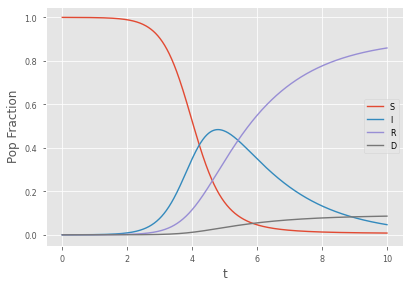

In [34]:
plot_results(t, result, labels=['S', 'I', 'R', 'D'])
plt.xlabel('t')
plt.ylabel('Pop Fraction')

In [35]:
class SIRDTrainable(tf.keras.Model):
  
  def __init__(self, beta, gama, mi, **kwargs):
    super().__init__(**kwargs)
    
    #Retire some parameters to allow training
    self.beta = beta
    self.gama = gama
    self.mi = mi
    
    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(4,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(4, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [S, I, R ,D]
    S, I, R, D = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 4]))  # [1, 4] -> [1, 4]
    
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    pred3 = n_out[0, 2]
    pred4 = n_out[0, 3]
    
    
    dS_dt = - self.beta*I*S +pred1 #pred1 = 0
    dI_dt = self.beta*I*S - self.gama*I - pred2 #pred2 = mi*I
    dR_dt =  self.gama*I + pred3  #pred3 = 0 
    dD_dt = self.mi*I + pred4  #pred4 = 0
    
    return tf.stack([dS_dt, dI_dt, dR_dt, dD_dt])

In [36]:
t_train = tf.linspace(0., 10, num=50)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1e-4, 0, 0], dtype=tf.float64)

beta = 2.8
gama = 0.5
mi = 0.05

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

In [37]:
from tensorflow.keras import backend as K
K.clear_session()

In [38]:
start = time.time()
with tf.device(device):
  model = SIRDTrainable(beta, gama, mi)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(SIRD(beta, gama, mi), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train, rtol = 1e-3)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()
end = time.time()
time_elapsed = end-start
print("Time elapsed: %f s" % time_elapsed)

Computing ground truth...
Ground truth shape : (50, 4)
Epoch 1
Loss : 0.013509906028340013
LR : 0.0099309245

Epoch 2
Loss : 0.00070041104205055
LR : 0.009862327

Epoch 3
Loss : 0.0007004230943656696
LR : 0.009794203

Epoch 4
Loss : 0.0007004310737631525
LR : 0.0097265495

Epoch 5
Loss : 0.0007004349169640267
LR : 0.009659363

Epoch 6
Loss : 0.0007004346521222099
LR : 0.009592641

Epoch 7
Loss : 0.0007004304037752736
LR : 0.009526379

Epoch 8
Loss : 0.0007004223746774816
LR : 0.009460577

Epoch 9
Loss : 0.0007004108270671038
LR : 0.009395227

Epoch 10
Loss : 0.0007007060428868117
LR : 0.0093303295

Epoch 11
Loss : 0.0007004663949293911
LR : 0.00926588

Epoch 12
Loss : 0.0007005065817972311
LR : 0.009201876

Epoch 13
Loss : 0.0007005065817972311
LR : 0.009138315

Epoch 14
Loss : 0.0007005065817972311
LR : 0.009075192

Epoch 15
Loss : 0.0007005065817972311
LR : 0.0090125045

Epoch 16
Loss : 0.0007005065817972311
LR : 0.00895025

Epoch 17
Loss : 0.0007005065817972311
LR : 0.008888427

Epo

In [39]:
from tfdiffeq.bfgs_optimizer import BFGSOptimizer

In [40]:
tolerance = 1e-3
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [41]:
from tfdiffeq.adjoint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-3, rtol=1e-3)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss


In [42]:
start = time.time()
model = bfgs_optimizer.minimize(loss_wrapper, model)
end = time.time()
time_elapsed = end - start
print("Time Elapsed: %f" % time_elapsed)

Iter: 1 loss: 0.00050868381786830553
BFGS complete, and parameters updated !
Time Elapsed: 0.577368


In [43]:
t_eval = tf.linspace(0., 10, num=1000)  # Re-evaluate for just 2 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(SIRD(beta, gama, mi), initial_states, t_eval)

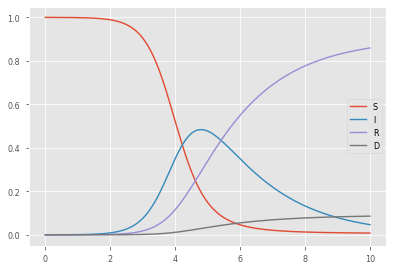

In [44]:
plot_results(t_eval, real_results, labels=['S', 'I', 'R', 'D'])

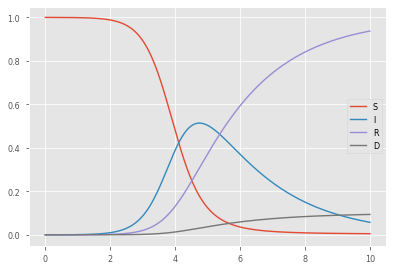

In [45]:
plot_results(t_eval, model_results, labels=['S', 'I', 'R', 'D'])

In [47]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [48]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import this optimizer for Ridge regression !
from tfdiffeq.sindy_utils import STRRidge

In [49]:
sindy_optm = SR3(threshold=0.1, nu=0.1, max_iter=500)
sindy_library = PolynomialLibrary(degree=20, include_interaction=True,  interaction_only=True)

In [50]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

C:\Users\ferna\Anaconda3\envs\tensorflow\lib\site-packages\pysindy\optimizers\sr3.py:269: ConvergenceWarning: SR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=20, interaction_only=True),
      feature_names=['x0', 'x1', 'x2', 'x3'],
      optimizer=SR3(max_iter=500, nu=0.1))

In [51]:
sindy_model.print()

x0' = -2.800 x0 x1 + 0.008 x0 x2 x3 + -0.022 x0 x1 x2 x3
x1' = -225.307 1 + 225.303 x0 + -84.011 x1 + 386.477 x2 + 38.648 x3 + 124.820 x0 x1 + 687.346 x0 x2 + 68.735 x0 x3 + 224.848 x1 x2 + 22.485 x1 x3 + -1793.270 x2 x3 + 128.865 x0 x1 x2 + 12.887 x0 x1 x3 + 26395.428 x0 x2 x3 + -1589.030 x1 x2 x3 + -1115.965 x0 x1 x2 x3
x2' = 0.500 x1 + 0.001 x0 x2 x3
x3' = 0.000


In [52]:
sindy_model.coefficients()

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.79994025e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  8.03879002e-03, -4.92228885e-04,
        -2.15747889e-02],
       [-2.25306892e+02,  2.25303078e+02, -8.40105990e+01,
         3.86477405e+02,  3.86477334e+01,  1.24819820e+02,
         6.87346062e+02,  6.87346055e+01,  2.24847771e+02,
         2.24847756e+01, -1.79326999e+03,  1.28865229e+02,
         1.28865226e+01,  2.63954278e+04, -1.58903021e+03,
        -1.11596539e+03],
       [ 0.00000000e+00,  0.00000000e+00,  4.99995183e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  6.17372844e-04,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e

In [53]:
sindy_model.score(model_preds_np, t_eval_np)

0.471149931208961